In [1]:
from getpass import getuser # Libaray to copy things
from tempfile import NamedTemporaryFile, TemporaryDirectory 

import dask

from dask.distributed import Client
import multiprocessing

ncpu = multiprocessing.cpu_count()
threads = 8
nworker = ncpu // threads
print(
    f"Number of CPUs: {ncpu}, number of threads: {threads}, number of workers: {nworker}"
)
client = Client(
    processes=True, threads_per_worker=threads, n_workers=nworker, memory_limit="100GB"
)
client 

# calculation
import metpy.calc as mpcalc

# scipy
from scipy import stats
from scipy.ndimage import measurements
from scipy import ndimage
from scipy.optimize import curve_fit

# for plot
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

# basic
from pathlib import Path # Object oriented libary to deal with paths
from dask.utils import format_bytes
from distributed import Client, progress, wait # Libaray to orchestrate distributed resources
import netCDF4 as nc
import numpy as np # Pythons standard array library
import xarray as xr # Libary to work with labeled n-dimensional data

# dask
import dask # Distributed data libary
import dask.distributed
import multiprocessing
from subprocess import run, PIPE
import warnings
warnings.filterwarnings(action='ignore')
import pandas as pd
dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})

Number of CPUs: 256, number of threads: 8, number of workers: 32


2024-11-27 14:28:07,786 - distributed.diskutils - INFO - Found stale lock file and directory '/home/m/m300948/ICON_AMZDEF/Project2/dask-worker-space/worker-667dxg3i', purging
2024-11-27 14:28:07,792 - distributed.diskutils - INFO - Found stale lock file and directory '/home/m/m300948/ICON_AMZDEF/Project2/dask-worker-space/worker-902mgohr', purging
2024-11-27 14:28:07,797 - distributed.diskutils - INFO - Found stale lock file and directory '/home/m/m300948/ICON_AMZDEF/Project2/dask-worker-space/worker-srq1eb95', purging
2024-11-27 14:28:07,804 - distributed.diskutils - INFO - Found stale lock file and directory '/home/m/m300948/ICON_AMZDEF/Project2/dask-worker-space/worker-68l4nxiv', purging
2024-11-27 14:28:07,810 - distributed.diskutils - INFO - Found stale lock file and directory '/home/m/m300948/ICON_AMZDEF/Project2/dask-worker-space/worker-y6kmmvjs', purging
2024-11-27 14:28:07,822 - distributed.diskutils - INFO - Found stale lock file and directory '/home/m/m300948/ICON_AMZDEF/Pro

In [2]:
import sys
sys.path.append('/home/m/m300948/ICON_AMZDEF')
import Tools

Number of CPUs: 256, number of threads: 8, number of workers: 32


# Load temperature data

In [3]:
# 2m air temperature
tas_ctl = xr.open_mfdataset('/scratch/m/m300948/test_04/2mt/ctl_daily_tas_202*',parallel=True)['tas']
tas_def = xr.open_mfdataset('/scratch/m/m300948/def_100/2mt/def_daily_tas_202*',parallel=True)['tas']

In [ ]:
# surface temperature
ts_ctl = xr.open_mfdataset('/scratch/m/m300948/test_04/surface_t/ctl_daily_ts_202*',parallel=True)['ts']
ts_def = xr.open_mfdataset('/scratch/m/m300948/def_100/surface_t/def_daily_ts_202*',parallel=True)['ts']

In [ ]:
# 2m air temperature
dew2_ctl = xr.open_mfdataset('/scratch/m/m300948/test_04/dew2/ctl_daily_dew2_2022*',parallel=True)['dew2']
dew2_def = xr.open_mfdataset('/scratch/m/m300948/def_100/dew2/def_daily_dew2_2022*',parallel=True)['dew2']

In [ ]:
# 2m air temperature
dew2_ctl = xr.open_mfdataset('/scratch/m/m300948/test_04/dew2/ctl_daily_dew2_2022*',parallel=True)['dew2']
dew2_def = xr.open_mfdataset('/scratch/m/m300948/def_100/dew2/def_daily_dew2_2022*',parallel=True)['dew2']

### Masking

In [4]:
dset_bd = xr.open_dataset('/work/mh0731/m300948/AMDEF/REGRID_BC/masking_files/AMAZON_Biome.nc')
AMZ_BD = dset_bd.AMAZON_BIOMES

In [5]:
ABinterp_biome = AMZ_BD.interp(latitude=tas_ctl.lat, longitude=tas_ctl.lon)

In [6]:
tas_ctl_mask = tas_ctl.where(ABinterp_biome == 0, np.nan).sel(lon=slice(-80,-40), lat=slice(-20,10))
tas_def_mask = tas_def.where(ABinterp_biome == 0, np.nan).sel(lon=slice(-80,-40), lat=slice(-20,10))

In [11]:
ts_ctl_mask = ts_ctl.where(ABinterp_biome == 0, np.nan).sel(lon=slice(-80,-40), lat=slice(-20,10))
ts_def_mask = ts_def.where(ABinterp_biome == 0, np.nan).sel(lon=slice(-80,-40), lat=slice(-20,10))

In [10]:
dew2_ctl_mask = dew2_ctl.where(ABinterp_biome == 0, np.nan).sel(lon=slice(-80,-40), lat=slice(-20,10))
dew2_def_mask = dew2_def.where(ABinterp_biome == 0, np.nan).sel(lon=slice(-80,-40), lat=slice(-20,10))

## Seasonal mean

In [7]:
# Surface radiation
xarray_names = ['tas_ctl_mask','tas_def_mask']

for name in xarray_names:
    xarray_data = globals()[name]
    
    xarray_data_month = xarray_data.groupby('time.month').mean('time')
    xarray_data_wet = xarray_data_month.where(xarray_data_month.month.isin([1,2,12]), drop=True).mean("month")
    xarray_data_dry = xarray_data_month.where(xarray_data_month.month.isin([7,8,9]), drop=True).mean("month")
        
    new_name_wet = name + '_wet'
    new_name_dry = name + '_dry'
        
    globals()[new_name_wet] = xarray_data_wet
    globals()[new_name_dry] = xarray_data_dry

In [8]:
print(tas_ctl_mask_wet.isel(height_2=0).mean(dim=['lat','lon']).values, tas_ctl_mask_dry.isel(height_2=0).mean(dim=['lat','lon']).values)
print(tas_def_mask_wet.isel(height_2=0).mean(dim=['lat','lon']).values, tas_def_mask_dry.isel(height_2=0).mean(dim=['lat','lon']).values)

296.77292 297.17212
300.0942 301.74084


In [15]:
print(tas_ctl_mask.isel(height_2=0).mean(dim=['time','lat','lon']).values, tas_def_mask.isel(height_2=0).mean(dim=['time','lat','lon']).values)

296.8172 300.65747


# PDF

In [7]:
xarray_names = ['tas_ctl_mask','tas_def_mask']
new_suffix = '_f'

for name in xarray_names:
    xarray_data = globals()[name]
    xarray_data_flat = xarray_data.values.flatten()
    xarray_data_f = xarray_data_flat[~np.isnan(xarray_data_flat)]
    new_name = name + new_suffix
    globals()[new_name] = xarray_data_f

In [9]:
print(np.max(tas_ctl_mask_f)-273, np.max(tas_ctl_mask_f)-273)
print(np.max(tas_def_mask_f)-273, np.max(tas_def_mask_f)-273)

41.205810546875 41.205810546875
44.893951416015625 44.893951416015625


In [23]:
np.min(tas_ctl_mask_f), np.max(tas_ctl_mask_f), np.min(tas_def_mask_f), np.max(tas_def_mask_f)

(0.0, 314.2058, 0.0, 317.89395)

In [9]:
count = np.sum(tas_ctl_mask_f - 273.19 > 45)
print(count)

0


In [10]:
count = np.sum(tas_def_mask_f - 273.19 > 45)
print(count)

0


In [9]:
# year/month separation
new_suffix = '_q99'

xarray_names = ['tas_ctl_mask','tas_def_mask']

for name in xarray_names:
    dset_name = name + '_f' 
    xarray_data = globals()[dset_name]
    xarray_data_q99 = np.nanquantile(xarray_data, 0.99, axis=0)

    new_name = dset_name + new_suffix
    globals()[new_name] = xarray_data_q99

In [ ]:
# year/month separation
new_suffix = '_mean'

xarray_names = ['tas_ctl_mask','tas_def_mask']

for name in xarray_names:
    dset_name = name + '_f' 
    xarray_data = globals()[dset_name]
    xarray_data_q99 = np.mean(xarray_data,axis=0)

    new_name = dset_name + new_suffix
    globals()[new_name] = xarray_data_q99

In [ ]:
xarray_names = ['ts_ctl_mask','ts_def_mask']
new_suffix = '_f'

for name in xarray_names:
    xarray_data = globals()[name]
    xarray_data_flat = xarray_data.values.flatten()
    xarray_data_f = xarray_data_flat[~np.isnan(xarray_data_flat)]
    new_name = name + new_suffix
    globals()[new_name] = xarray_data_f

In [10]:
# year/month separation
new_suffix = '_q99'

xarray_names = ['ts_ctl_mask','ts_def_mask']

for name in xarray_names:
    dset_name = name + '_f' 
    xarray_data = globals()[dset_name]
    xarray_data_q99 = np.nanquantile(xarray_data, 0.99, axis=0)

    new_name = dset_name + new_suffix
    globals()[new_name] = xarray_data_q99

In [156]:
def plot_pdf(data_ctl, data_def, bins, label_ctl, label_def, xlabel, xmin, xmax, p99_1, p99_2):
    pdf_ctl, bins_ctl = np.histogram(data_ctl, bins=bins, density=True)  # Adjust the number of bins as needed
    pdf_def, bins_def = np.histogram(data_def, bins=bins, density=True)

    # Calculate the bin centers
    bin_centers_ctl = (bins_ctl[:-1] + bins_ctl[1:]) / 2
    bin_centers_def = (bins_def[:-1] + bins_def[1:]) / 2
    
    # Calculate the bin width
    bin_width_ctl = np.diff(bins_ctl)
    bin_width_def = np.diff(bins_def)
    
    # Normalize the PDF
    pdf_normalized_ctl = pdf_ctl / pdf_ctl.sum()*bin_width_ctl
    pdf_normalized_def = pdf_def / pdf_def.sum()*bin_width_def
    
    cmap = matplotlib.cm.get_cmap('PiYG')
    left = cmap(0.0)
    right = cmap(1.0)

    # Plot the PDF
    fig, ax = plt.subplots(figsize=(12,8))
    plt.plot(bin_centers_ctl, pdf_normalized_ctl, label=label_ctl, color=right, linewidth=5)
    plt.plot(bin_centers_def, pdf_normalized_def, label=label_def, color=left, linewidth=5, ls='--')

    # Set labels and title
    plt.xlabel(xlabel, fontsize='30')
    plt.ylabel('PDF', fontsize='30')
    #plt.title(title, fontsize='20')
    #plt.yscale('log')
    plt.xlim(xmin, xmax)

    # plot p99
    if p99_1 is not None:
        plt.axvline(p99_1, color=right, ls=':', linewidth=3.5)
    if p99_2 is not None:
        plt.axvline(p99_2, color=left, ls=':', linewidth=3.5)
    #plt.axvline(p99_1, color=right, ls=':', linewidth=3.5)
    #plt.axvline(p99_2, color=left, ls=':', linewidth=3.5)

    plt.xticks(fontsize=30,rotation=0)
    plt.yticks(fontsize=30)
   
    # add legend
    plt.legend(fontsize=30)
    
    # remove top and right spines
    ax.spines[['right', 'top']].set_visible(False)

    # Display the plot
    plt.show()

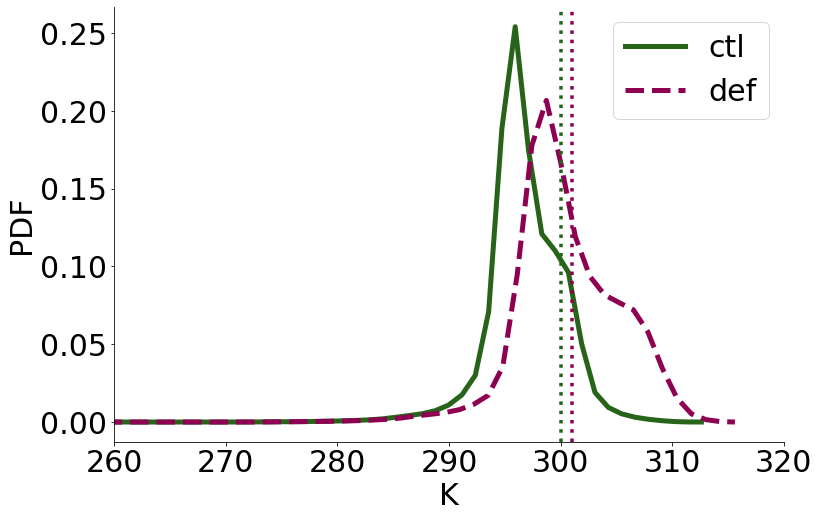

In [52]:
plot_pdf(tas_ctl_mask_f, tas_def_mask_f, 50, 'ctl', 'def', 'K', 260, 320, 300, 301)

## Max, Min temperature

In [8]:
tas_max_ctl_mask = tas_ctl_mask.resample(time='1D').max()
tas_max_def_mask = tas_def_mask.resample(time='1D').max()

In [9]:
tas_min_ctl_mask = tas_ctl_mask.resample(time='1D').min()
tas_min_def_mask = tas_def_mask.resample(time='1D').min()

In [10]:
xarray_names = ['tas_max_ctl_mask','tas_max_def_mask']
new_suffix = '_f'

for name in xarray_names:
    xarray_data = globals()[name]
    xarray_data_flat = xarray_data.values.flatten()
    xarray_data_f = xarray_data_flat[~np.isnan(xarray_data_flat)]
    new_name = name + new_suffix
    globals()[new_name] = xarray_data_f

/home/m/m300948/.conda/envs/JUPYTER_MODULE/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/home/m/m300948/.conda/envs/JUPYTER_MODULE/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/home/m/m300948/.conda/envs/JUPYTER_MODULE/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/home/m/m300948/.conda/envs/JUPYTER_MODULE/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/home/m/m300948/.conda/envs/JUPYTER_MODULE/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepd

In [11]:
# year/month separation
new_suffix = '_mean'

xarray_names = ['tas_max_ctl_mask','tas_max_def_mask']

for name in xarray_names:
    dset_name = name + '_f' 
    xarray_data = globals()[dset_name]
    xarray_data_q99 = np.mean(xarray_data,axis=0)

    new_name = dset_name + new_suffix
    globals()[new_name] = xarray_data_q99

In [11]:
xarray_names = ['tas_min_ctl_mask','tas_min_def_mask']
new_suffix = '_f'

for name in xarray_names:
    xarray_data = globals()[name]
    xarray_data_flat = xarray_data.values.flatten()
    xarray_data_f = xarray_data_flat[~np.isnan(xarray_data_flat)]
    new_name = name + new_suffix
    globals()[new_name] = xarray_data_f

/home/m/m300948/.conda/envs/JUPYTER_MODULE/lib/python3.9/site-packages/dask/array/reductions.py:579: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)
/home/m/m300948/.conda/envs/JUPYTER_MODULE/lib/python3.9/site-packages/dask/array/reductions.py:579: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)
/home/m/m300948/.conda/envs/JUPYTER_MODULE/lib/python3.9/site-packages/dask/array/reductions.py:579: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)
/home/m/m300948/.conda/envs/JUPYTER_MODULE/lib/python3.9/site-packages/dask/array/reductions.py:579: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)
/home/m/m300948/.conda/envs/JUPYTER_MODULE/lib/python3.9/site-packages/dask/array/reductions.py:579: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepd

In [48]:
# year/month separation
new_suffix = '_mean'

xarray_names = ['tas_min_ctl_mask','tas_min_def_mask']

for name in xarray_names:
    dset_name = name + '_f' 
    xarray_data = globals()[dset_name]
    xarray_data_q99 = np.mean(xarray_data,axis=0)

    new_name = dset_name + new_suffix
    globals()[new_name] = xarray_data_q99

In [53]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

In [29]:
print(np.shape(tas_max_ctl_mask_f), np.shape(tas_max_def_mask_f), np.shape(tas_min_ctl_mask_f), np.shape(tas_min_def_mask_f), np.shape(tas_ctl_mask_f), np.shape(tas_def_mask_f))

(56744772,) (57442014,) (56744772,) (57442014,) (2707444320,) (2748420696,)


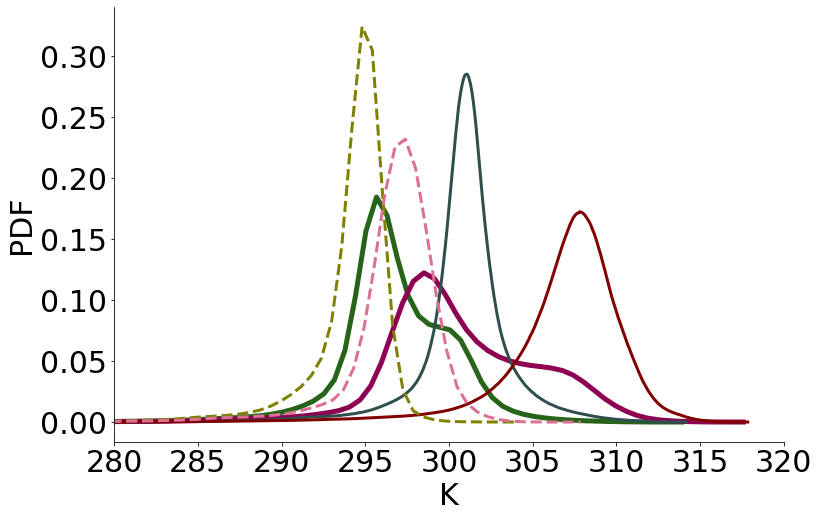

In [13]:
from matplotlib.ticker import ScalarFormatter
pdf_ctl, bins_ctl = np.histogram(tas_ctl_mask_f, bins=500, density=True)  # Adjust the number of bins as needed
pdf_def, bins_def = np.histogram(tas_def_mask_f, bins=500, density=True)
pdf_max_ctl, bins_max_ctl = np.histogram(tas_max_ctl_mask_f, bins=500, density=True)  # Adjust the number of bins as needed
pdf_max_def, bins_max_def = np.histogram(tas_max_def_mask_f, bins=500, density=True)
pdf_min_ctl, bins_min_ctl = np.histogram(tas_min_ctl_mask_f, bins=500, density=True)  # Adjust the number of bins as needed
pdf_min_def, bins_min_def = np.histogram(tas_min_def_mask_f, bins=500, density=True)

# Calculate the bin centers
bin_centers_ctl = (bins_ctl[:-1] + bins_ctl[1:]) / 2
bin_centers_def = (bins_def[:-1] + bins_def[1:]) / 2
bin_max_centers_ctl = (bins_max_ctl[:-1] + bins_max_ctl[1:]) / 2
bin_max_centers_def = (bins_max_def[:-1] + bins_max_def[1:]) / 2
bin_min_centers_ctl = (bins_min_ctl[:-1] + bins_min_ctl[1:]) / 2
bin_min_centers_def = (bins_min_def[:-1] + bins_min_def[1:]) / 2

# Calculate the bin width
bin_width_ctl = np.diff(bins_ctl)
bin_width_def = np.diff(bins_def)
bin_width_max_ctl = np.diff(bins_max_ctl)
bin_width_max_def = np.diff(bins_max_def)
bin_width_min_ctl = np.diff(bins_min_ctl)
bin_width_min_def = np.diff(bins_min_def)

# Normalize the PDF
pdf_normalized_ctl = pdf_ctl / pdf_ctl.sum()*bin_width_ctl
pdf_normalized_def = pdf_def / pdf_def.sum()*bin_width_def
pdf_normalized_max_ctl = pdf_max_ctl / pdf_max_ctl.sum()*bin_width_max_ctl
pdf_normalized_max_def = pdf_max_def / pdf_max_def.sum()*bin_width_max_def
pdf_normalized_min_ctl = pdf_min_ctl / pdf_min_ctl.sum()*bin_width_min_ctl
pdf_normalized_min_def = pdf_min_def / pdf_min_def.sum()*bin_width_min_def

cmap = matplotlib.cm.get_cmap('PiYG')
left = cmap(0.0)
right = cmap(1.0)

# Plot the PDF
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(bin_centers_ctl, pdf_ctl, label='CTL', color=right, linewidth=5)
plt.plot(bin_centers_def, pdf_def, label='DEF', color=left, linewidth=5)
plt.plot(bin_max_centers_ctl, pdf_max_ctl, label='CTL_Tmax', color='darkslategray', linewidth=3)
plt.plot(bin_max_centers_def, pdf_max_def,label='DEF_Tmax', color='maroon', linewidth=3)
plt.plot(bin_min_centers_ctl, pdf_min_ctl, label='CTL_Tmin', color='olive', linewidth=3, ls='--')
plt.plot(bin_min_centers_def, pdf_min_def, label='DEF_Tmin', color='palevioletred', linewidth=3, ls='--')


# Set labels and title#
plt.xlabel('K', fontsize='30')
plt.ylabel('PDF', fontsize='30')
#plt.title(title, fontsize='20')
#plt.yscale('log')
plt.xlim(280, 320)


plt.xticks(fontsize=30,rotation=0)
plt.yticks(fontsize=30)

# add legend
#plt.legend(fontsize=30)

# remove top and right spines
ax.spines[['right', 'top']].set_visible(False)

# Force y-axis to use fixed-point notation (non-scientific)
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=False))  # This avoids scientific notation
ax.ticklabel_format(style='plain', axis='y') 

# Display the plot
plt.show()

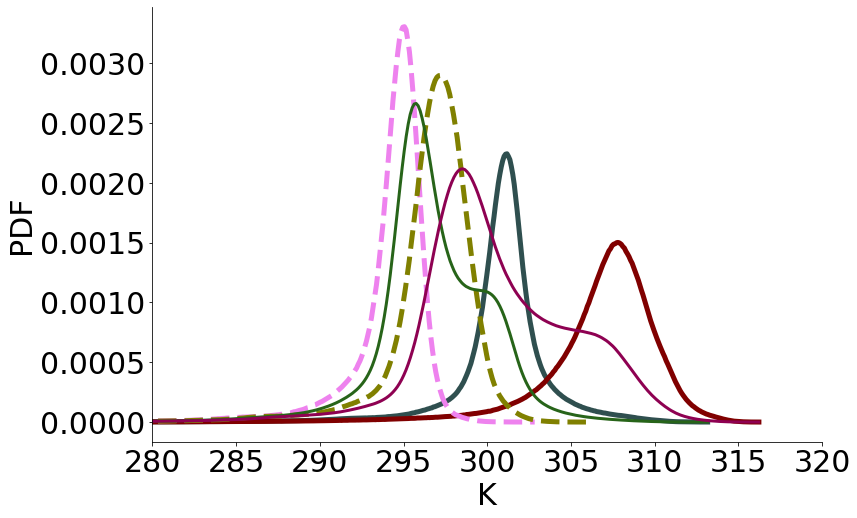

In [50]:
#def plot_pdf(data_ctl, data_def, bins, label_ctl, label_def, xlabel, xmin, xmax, p99_1, p99_2):
pdf_ctl, bins_ctl = np.histogram(tas_ctl_mask_f, bins=500, density=True)  # Adjust the number of bins as needed
pdf_def, bins_def = np.histogram(tas_def_mask_f, bins=500, density=True)
pdf_max_ctl, bins_max_ctl = np.histogram(tas_max_ctl_mask_f, bins=500, density=True)  # Adjust the number of bins as needed
pdf_max_def, bins_max_def = np.histogram(tas_max_def_mask_f, bins=500, density=True)
pdf_min_ctl, bins_min_ctl = np.histogram(tas_min_ctl_mask_f, bins=500, density=True)  # Adjust the number of bins as needed
pdf_min_def, bins_min_def = np.histogram(tas_min_def_mask_f, bins=500, density=True)


# Calculate the bin centers
bin_centers_ctl = (bins_ctl[:-1] + bins_ctl[1:]) / 2
bin_centers_def = (bins_def[:-1] + bins_def[1:]) / 2
bin_centers_max_ctl = (bins_max_ctl[:-1] + bins_max_ctl[1:]) / 2
bin_centers_max_def = (bins_max_def[:-1] + bins_max_def[1:]) / 2
bin_centers_min_ctl = (bins_min_ctl[:-1] + bins_min_ctl[1:]) / 2
bin_centers_min_def = (bins_min_def[:-1] + bins_min_def[1:]) / 2

####################################################
# Calculate the bin width
bin_width_ctl = np.diff(bins_ctl) 
bin_width_def = np.diff(bins_def) 
bin_width_max_ctl = np.diff(bins_max_ctl)
bin_width_max_def = np.diff(bins_max_def) 
bin_width_min_ctl = np.diff(bins_min_ctl) 
bin_width_min_def = np.diff(bins_min_def) 

# Normalize the PDF
pdf_normalized_ctl = pdf_ctl / pdf_ctl.sum()*bin_width_ctl
pdf_normalized_def = pdf_def / pdf_def.sum()*bin_width_def
pdf_normalized_max_ctl = pdf_max_ctl / pdf_max_ctl.sum()*bin_width_max_ctl
pdf_normalized_max_def = pdf_max_def / pdf_max_def.sum()*bin_width_max_def
pdf_normalized_min_ctl = pdf_min_ctl / pdf_min_ctl.sum()*bin_width_min_ctl
pdf_normalized_min_def = pdf_min_def / pdf_min_def.sum()*bin_width_min_def
####################################################

# Step 3: Ensure consistent normalization
#pdf_normalized_ctl = pdf_ctl * np.diff(bins_ctl)
#pdf_normalized_def = pdf_def * np.diff(bins_def)
#pdf_normalized_max_ctl = pdf_max_ctl * np.diff(bins_max_ctl)
#pdf_normalized_max_def = pdf_max_def * np.diff(bins_max_def)
#pdf_normalized_min_ctl = pdf_min_ctl * np.diff(bins_min_ctl)
#pdf_normalized_min_def = pdf_min_def * np.diff(bins_min_def)


cmap = matplotlib.cm.get_cmap('PiYG')
left = cmap(0.0)
right = cmap(1.0)

# Plot the PDF
fig, ax = plt.subplots(figsize=(12,8))

plt.plot(bin_centers_max_ctl, pdf_normalized_max_ctl, label='CTL_Tmax', color='darkslategray', linewidth=5)
plt.plot(bin_centers_max_def, pdf_normalized_max_def, label='DEF_Tmax', color='maroon', linewidth=5)
plt.plot(bin_centers_min_ctl, pdf_normalized_min_ctl, label='CTL_Tmin', color='violet', linewidth=5, ls='--')
plt.plot(bin_centers_min_def, pdf_normalized_min_def, label='DEF_Tmin', color='olive', linewidth=5, ls='--')

plt.plot(bin_centers_ctl, pdf_normalized_ctl, label='CTL', color=right, linewidth=3)
plt.plot(bin_centers_def, pdf_normalized_def, label='DEF', color=left, linewidth=3)

# Set labels and title
plt.xlabel('K', fontsize='30')
plt.ylabel('PDF', fontsize='30')
#plt.title(title, fontsize='20')
#plt.yscale('log')
plt.xlim(280, 320)

# plot p99
#if p99_1 is not None:
#    plt.axvline(p99_1, color=right, ls=':', linewidth=3.5)
#if p99_2 is not None:
#    plt.axvline(p99_2, color=left, ls=':', linewidth=3.5)
#plt.axvline(tas_ctl_mask_f_mean, color=right, ls=':', linewidth=3.5)
#plt.axvline(tas_def_mask_f_mean, color=left, ls=':', linewidth=3.5)
#plt.axvline(tas_max_ctl_mask_f_mean, color='darkkhaki', ls=':', linewidth=3.5)
#plt.axvline(tas_max_def_mask_f_mean, color='pink', ls=':', linewidth=3.5)

plt.xticks(fontsize=30,rotation=0)
plt.yticks(fontsize=30)

# add legend
#plt.legend(fontsize=30)

# remove top and right spines
ax.spines[['right', 'top']].set_visible(False)

# Display the plot
plt.show()

In [59]:
print(tas_def_mask_f_mean-tas_ctl_mask_f_mean, tas_max_def_mask_f_mean-tas_max_ctl_mask_f_mean,tas_min_def_mask_f_mean-tas_min_ctl_mask_f_mean)

3.7422485 5.8458557 2.4737854


## PDF of seasonal temperature

In [7]:
# max
ctl_daily_max_all_months = tas_ctl_mask.resample(time='1D').max(dim='time')
def_daily_max_all_months = tas_def_mask.resample(time='1D').max(dim='time')

In [9]:
# min
ctl_daily_min_all_months = tas_ctl_mask.resample(time='1D').min(dim='time')
def_daily_min_all_months = tas_def_mask.resample(time='1D').min(dim='time')

In [10]:
# mean
ctl_daily_mean_all_months = tas_ctl_mask.resample(time='1D').mean(dim='time')
def_daily_mean_all_months = tas_def_mask.resample(time='1D').mean(dim='time')

_caculate mean, min, max for each month_

In [11]:
# max
month_name = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
monthly_ctl_max_arrays = {}
monthly_def_max_arrays = {}

for i in range(12):
    monthly_ctl_max_arrays[month_name[i]] = ctl_daily_max_all_months.sel(time=ctl_daily_max_all_months.time.dt.month == i+1)
    monthly_def_max_arrays[month_name[i]] = def_daily_max_all_months.sel(time=def_daily_max_all_months.time.dt.month == i+1)
    #jan_def = def_daily_max_all_months.sel(time=def_daily_max_all_months.time.dt.month == i+1)
    
#jan_ctl = ctl_daily_max_all_months.sel(time=ctl_daily_max_all_months.time.dt.month == 1)
#jan_def = def_daily_max_all_months.sel(time=def_daily_max_all_months.time.dt.month == 1)

In [12]:
# min
month_name = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
monthly_ctl_min_arrays = {}
monthly_def_min_arrays = {}

for i in range(12):
    monthly_ctl_min_arrays[month_name[i]] = ctl_daily_min_all_months.sel(time=ctl_daily_min_all_months.time.dt.month == i+1)
    monthly_def_min_arrays[month_name[i]] = def_daily_min_all_months.sel(time=def_daily_min_all_months.time.dt.month == i+1)

In [13]:
# mean
month_name = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
monthly_ctl_mean_arrays = {}
monthly_def_mean_arrays = {}

for i in range(12):
    monthly_ctl_mean_arrays[month_name[i]] = ctl_daily_mean_all_months.sel(time=ctl_daily_mean_all_months.time.dt.month == i+1)
    monthly_def_mean_arrays[month_name[i]] = def_daily_mean_all_months.sel(time=def_daily_mean_all_months.time.dt.month == i+1)

_flatten the dataset_

In [14]:
# mean
xarray_names = ['monthly_ctl_mean_arrays','monthly_def_mean_arrays']
new_suffix = '_f'
monthly_ctl_mean_arrays_f = {}
monthly_def_mean_arrays_f = {}

for name in xarray_names:
    for month in month_name:
        xarray_data = globals()[name][month]
        xarray_data_flat = xarray_data.values.flatten()
        xarray_data_f = xarray_data_flat[~np.isnan(xarray_data_flat)]
        new_name = name + new_suffix
        globals()[new_name][month] = xarray_data_f

In [16]:
# CTL Max (wet)
selected_months_ctl_max = [monthly_ctl_max_arrays['jan'],
                   monthly_ctl_max_arrays['feb'],
                   monthly_ctl_max_arrays['dec']]
combined_data_ctl_max = xr.concat(selected_months_ctl_max, dim='month')
wet_results_ctl_max = combined_data_ctl_max.mean(dim=['month','time','lat','lon']) 

In [17]:
# CTL Max (dry)
selected_months_ctl_max = [monthly_ctl_max_arrays['jul'],
                   monthly_ctl_max_arrays['aug'],
                   monthly_ctl_max_arrays['sep']]
combined_data_ctl_max = xr.concat(selected_months_ctl_max, dim='month')
dry_results_ctl_max = combined_data_ctl_max.mean(dim=['month','time','lat','lon']) 

In [18]:
# CTL Min (wet)
selected_months_ctl_min = [monthly_ctl_min_arrays['jan'],
                   monthly_ctl_min_arrays['feb'],
                   monthly_ctl_min_arrays['dec']]
combined_data_ctl_min = xr.concat(selected_months_ctl_min, dim='month')
wet_results_ctl_min = combined_data_ctl_min.mean(dim=['month','time','lat','lon']) 

In [19]:
# CTL Min (dry)
selected_months_ctl_min = [monthly_ctl_min_arrays['jul'],
                   monthly_ctl_min_arrays['aug'],
                   monthly_ctl_min_arrays['sep']]
combined_data_ctl_min = xr.concat(selected_months_ctl_min, dim='month')
dry_results_ctl_min = combined_data_ctl_min.mean(dim=['month','time','lat','lon']) 

In [20]:
# DEF MAX (wet)
selected_months_def_max = [monthly_def_max_arrays['jan'],
                   monthly_def_max_arrays['feb'],
                   monthly_def_max_arrays['dec']]
combined_data_def_max = xr.concat(selected_months_def_max, dim='month')
wet_results_def_max = combined_data_def_max.mean(dim=['month','time','lat','lon']) 

In [21]:
# DEF MAX (dry)
selected_months_def_max = [monthly_def_max_arrays['jul'],
                   monthly_def_max_arrays['aug'],
                   monthly_def_max_arrays['sep']]
combined_data_def_max = xr.concat(selected_months_def_max, dim='month')
dry_results_def_max = combined_data_def_max.mean(dim=['month','time','lat','lon']) 

In [22]:
# DEF min (wet)
selected_months_def_min = [monthly_def_min_arrays['jan'],
                   monthly_def_min_arrays['feb'],
                   monthly_def_min_arrays['dec']]
combined_data_def_min = xr.concat(selected_months_def_min, dim='month')
wet_results_def_min = combined_data_def_min.mean(dim=['month','time','lat','lon']) 

In [27]:
# DEF min (dry)
selected_months_def_min = [monthly_def_min_arrays['jul'],
                   monthly_def_min_arrays['aug'],
                   monthly_def_min_arrays['sep']]
combined_data_def_min = xr.concat(selected_months_def_min, dim='month')
dry_results_def_min = combined_data_def_min.mean(dim=['month','time','lat','lon']) 

In [28]:
print(wet_results_ctl_max.values, dry_results_ctl_max.values, wet_results_ctl_min.values, dry_results_ctl_min.values)
print(wet_results_def_max.values, dry_results_def_max.values, wet_results_def_min.values, dry_results_def_min.values)

[300.4615] [301.89804] [293.42175] [293.92612]
[305.98636] [308.3271] [295.3783] [297.2968]


_Plot the figure with mean + max, min_

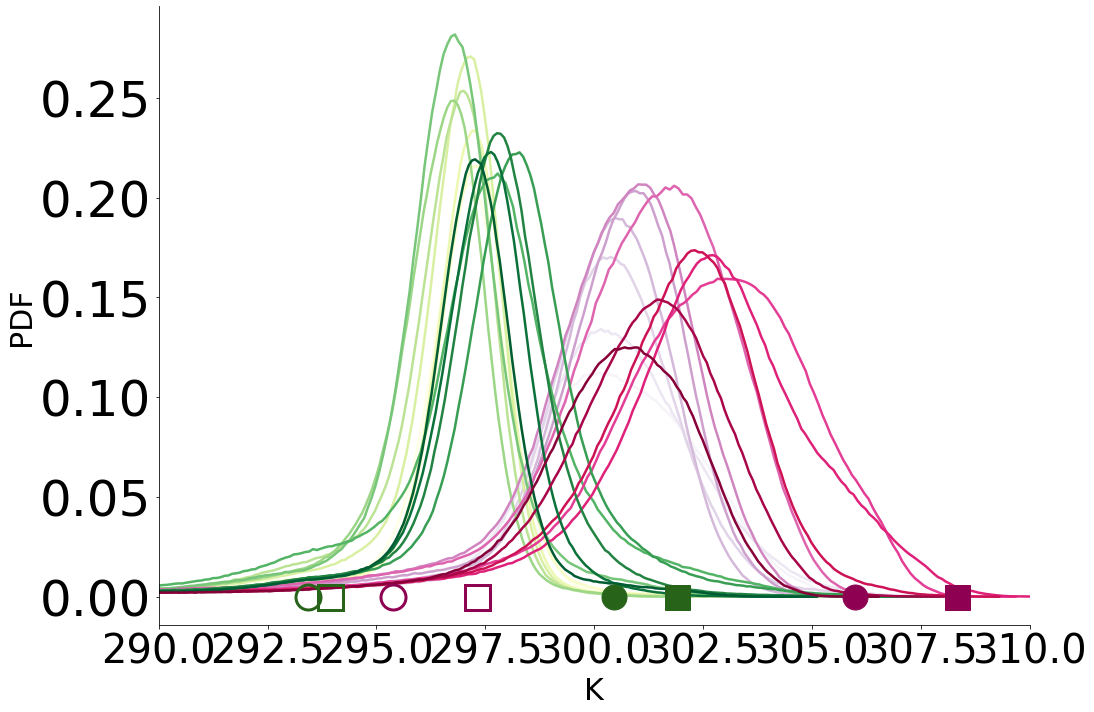

In [30]:
from matplotlib.ticker import ScalarFormatter
month_name = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']

fig, ax = plt.subplots(figsize=(18,10))

left = matplotlib.cm.get_cmap('PuRd')
right = matplotlib.cm.get_cmap('YlGn')

colors_ctl = [right(i / 12) for i in range(12)]
colors_def = [left(i / 12) for i in range(12)]

ctl_handles = []
def_handles = []
ctl_labels=[]
def_labels=[]

for i in range(12):
    month = month_name[i]
    
    # Calculate PDFs
    pdf_ctl, bins_ctl = np.histogram(monthly_ctl_mean_arrays_f[month], bins=500, density=True)
    pdf_def, bins_def = np.histogram(monthly_def_mean_arrays_f[month], bins=500, density=True)

    # Calculate the bin centers
    bin_centers_ctl = (bins_ctl[:-1] + bins_ctl[1:]) / 2
    bin_centers_def = (bins_def[:-1] + bins_def[1:]) / 2

    # Calculate the bin width
    bin_width_ctl = np.diff(bins_ctl)
    bin_width_def = np.diff(bins_def)

    # Normalize the PDF
    pdf_normalized_ctl = pdf_ctl / pdf_ctl.sum() * bin_width_ctl
    pdf_normalized_def = pdf_def / pdf_def.sum() * bin_width_def

    # Plot the PDFs for each month
    line_ctl, = ax.plot(bin_centers_ctl, pdf_normalized_ctl * 100, label=f'CTL {month.upper()}', color=colors_ctl[i], linewidth=2.5)
    line_def, = ax.plot(bin_centers_def, pdf_normalized_def * 100, label=f'DEF {month.upper()}', color=colors_def[i], linewidth=2.5)
    
    ctl_handles.append(line_ctl)
    def_handles.append(line_def)
    ctl_labels.append(f'CTL {month.upper()}')
    def_labels.append(f'DEF {month.upper()}')

# add min, max dots
cmap = matplotlib.cm.get_cmap('PiYG')
def_color = cmap(0.0)
ctl_color = cmap(1.0)
# WET
ax.plot(wet_results_ctl_max, 0, 'o', color=ctl_color, markersize=25, label='CTL Max')
ax.plot(wet_results_def_max, 0, 'o', color=def_color, markersize=25, label='DEF Max')
ax.plot(wet_results_ctl_min, 0, 'o', color=ctl_color, markersize=25, label='CTL Min', mfc='none', linestyle='--', mew=3)
ax.plot(wet_results_def_min, 0, 'o', color=def_color, markersize=25, label='DEF Min', mfc='none', linestyle='--', mew=3)
# DRY
ax.plot(dry_results_ctl_max, 0, 's', color=ctl_color, markersize=25, label='CTL Max')
ax.plot(dry_results_def_max, 0, 's', color=def_color, markersize=25, label='DEF Max')
ax.plot(dry_results_ctl_min, 0, 's', color=ctl_color, markersize=25, label='CTL Min', mfc='none', linestyle='--', mew=3)
ax.plot(dry_results_def_min, 0, 's', color=def_color, markersize=25, label='DEF Min', mfc='none', linestyle='--', mew=3)

# Set labels and title
plt.xlabel('K', fontsize=30)
plt.ylabel('PDF', fontsize=30)
plt.xlim(290, 310)

plt.xticks(fontsize=40, rotation=0)
plt.yticks(fontsize=50)

#plt.legend(ctl_handles + def_handles, ctl_labels + def_labels, fontsize=15, loc='upper right', ncol=2, frameon=False,bbox_to_anchor=(1, 1))

# Adjust legend positioning
#plt.gca().get_legend().get_frame().set_linewidth(0)  # Remove legend frame
#plt.gca().get_legend().set_bbox_to_anchor((1, 1), transform=plt.gca().transAxes)  # Adjust position

# Remove top and right spines
ax.spines[['right', 'top']].set_visible(False)

# Force y-axis to use fixed-point notation (non-scientific)
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=False))
ax.ticklabel_format(style='plain', axis='y')

# Display the plot
plt.tight_layout(rect=[0, 0, 0.85, 1]) 
plt.show()

# Seaonal change - Object detection

_call data_

In [ ]:
#Define a global pattern to find the files
###cloud liquid water 
glob_pattern_3d1 = 'ctl_daily_tas_202'
## Define the paths of file 1 (dppp0016)
data_path1 = Path('/scratch/m/m300948/test_04/2mt')
## Collect all file names with pathlib's rglob and list compression  -- cloud liquid water 
file_icon_tas = sorted([str(f) for f in data_path1.rglob(f'*{glob_pattern_3d1}*.nc')])[:]

In [ ]:
#Define a global pattern to find the files
###cloud liquid water 
glob_pattern_3d1 = 'def_daily_tas_202'
## Define the paths of file 1 (dppp0016)
data_path1 = Path('/scratch/m/m300948/def_100/2mt')
## Collect all file names with pathlib's rglob and list compression  -- cloud liquid water 
file_def_tas = sorted([str(f) for f in data_path1.rglob(f'*{glob_pattern_3d1}*.nc')])[:]

In [ ]:
#ctline a global pattern to find the files
###cloud liquid water 
glob_pattern_3d1 = 'ctl_daily_hus_plev_202'
## ctline the paths of file 1 (dppp0016)
data_path1 = Path('/scratch/m/m300948/test_04/3d/specif_humidity/6hourly/')
## Collect all file names with pathlib's rglob and list compression  -- cloud liquid water 
file_ctl_hus = sorted([str(f) for f in data_path1.rglob(f'{glob_pattern_3d1}*.nc')])[:]

In [ ]:
#define a global pattern to find the files
###cloud liquid water 
glob_pattern_3d1 = 'def_daily_hus_plev_'
## define the paths of file 1 (dppp0016)
data_path1 = Path('/scratch/m/m300948/def_100/3d/specif_humidity/6hourly')
## Collect all file names with pathlib's rglob and list compression  -- cloud liquid water 
file_def_hus = sorted([str(f) for f in data_path1.rglob(f'{glob_pattern_3d1}*.nc')])[:]

In [ ]:
def mask_cal(dset):
    ##This function calculate the land_sea mask according to the resolution of the data##
    ###negative values is ocean, positive values is land
    filemask = '/work/mh0731/from_Mistral/mh0731/m300876/land_sea_mask/GPM_IMERG_LandSeaMask.2.nc4'
    dsetmask = xr.open_dataset(filemask)
    lsmask01 = dsetmask.landseamask.where(
        dsetmask.landseamask<100).interp(lon=dset.lon.values,lat=dset.lat.values,method='linear') *0 +2
    lsmask01 = lsmask01.where(lsmask01==2,-2)
    return lsmask01

In [ ]:
# 1MS, 1H, 1D, 1Y
def time_mean_model(file,times,var,lat,lon,environ):
    ##Funtion to calculate the monthly mean of tasecipitation from the model
    ###the environ option mask the values over land or ocean:
        ## if environ = 'trop' -> no mask is used
        ## if environ = 'ocean' -> return only values over ocean
        ## if environ = 'land' -> return only values over land
    dset = xr.open_mfdataset(file, engine='netcdf4', combine='by_coords',chunks=({'time':20})).sel(
        time=slice(times[0],times[1]))
    if environ == 'trop':
        tas=dset[var].sel(
            time=slice(times[0],times[1])).sel(
            lat=slice(lat[0],lat[1]),lon=slice(lon[0],lon[1])).resample(time='1MS').mean(dim=('time'),skipna=True) 
    else:
        lsmask01 = mask_cal(dset)
        if environ == 'ocean':
            tas=dset[var].where(lsmask01<0).sel(lat=slice(lat[0],lat[1]),lon=slice(lon[0],lon[1])).resample(
                time='1MS').mean(dim=('time'),skipna=True)
        elif environ == 'land':
            tas=dset[var].where(lsmask01>0).sel(lat=slice(lat[0],lat[1]),lon=slice(lon[0],lon[1])).resample(
                time='1MS').mean(dim=('time'),skipna=True)
        else:
            return tasint('no correct environment')
    jobs = dask.persist(tas)
    varf = dask.compute(tas)[0]
    #tas_mon = varf.groupby('time.month').mean()
    tas_mon = varf
    return tas_mon

In [ ]:
times = ['2020-01-01','2022-12-31']
var = 'tas'
pr_ctl_land = time_mean_model(file_icon_tas,times,var,[-30,13],[-82,-30],'land')

In [ ]:
times = ['2020-01-01','2022-12-31']
var = 'tas'
pr_def_land = time_mean_model(file_def_tas,times,var,[-30,13],[-82,-30],'land')

In [ ]:
times = ['2022-01-01','2022-12-31']
var = 'hus'
hus_ctl_land = time_mean_model(file_ctl_hus,times,var,[-30,13],[-82,-30],'land')

In [ ]:
times = ['2022-01-01','2022-12-31']
var = 'hus'
hus_def_land = time_mean_model(file_def_hus,times,var,[-30,13],[-82,-30],'land')

In [ ]:
ABinterp_biome = AMZ_BD.interp(latitude=pr_ctl_land.lat, longitude=pr_ctl_land.lon)

In [ ]:
tas_ctl_mask = pr_ctl_land.isel(height_2=0).where(ABinterp_biome == 0, np.nan).sel(lon=slice(-80,-40), lat=slice(-20,10))
tas_def_mask = pr_def_land.isel(height_2=0).where(ABinterp_biome == 0, np.nan).sel(lon=slice(-80,-40), lat=slice(-20,10))

In [ ]:
hus_ctl_mask = hus_ctl_land.where(ABinterp_biome == 0, np.nan).sel(lon=slice(-80,-40), lat=slice(-20,10))
hus_def_mask = hus_def_land.where(ABinterp_biome == 0, np.nan).sel(lon=slice(-80,-40), lat=slice(-20,10))

### Object detection

In [53]:
# avgerage three years mean over month
tas_ctl_land_month = pr_ctl_land.isel(height_2=0).groupby('time.month').mean('time').transpose('month','lat','lon')
tas_def_land_month = pr_def_land.isel(height_2=0).groupby('time.month').mean('time').transpose('month','lat','lon')

In [54]:
tas_ctl_land_month = tas_ctl_land_month.where(tas_ctl_land_month>=0,0)
tas_def_land_month = tas_def_land_month.where(tas_def_land_month>=0,0)

In [7]:
def calc_area(data,dx,dy):
    ##Calculate the area of each grid cell in the data
    earthr = 6.371e6
    loncmorph,latcmorph = np.meshgrid(data.lon.values,data.lat.values)
    area = xr.DataArray(data = (dx/180*np.pi)*earthr*np.cos(latcmorph/180*np.pi)*(dy/180*np.pi)*earthr,
                            dims=["lat","lon"],
                            coords=dict(
                            lat=(["lat"],data.lat.values),
                            lon=(["lon"],data.lon.values),))
    return area

In [8]:
def calc_objects(data,threshold,structure):
    ## This function calculates the objects of precipitation according to a threshold and a strcuture
    labels,num = measurements.label(data.where(data>threshold,0),structure=structure)
    ###sorting labels according to index
    labelsu = np.unique(labels);
    labels_n = np.searchsorted(labelsu,labels); 
    indices_n = np.arange(np.max(labels_n)+1);
    return labels_n,indices_n

In [9]:
def cal_statistic(data,area_grid,labels_n,indices_n,threshold):
    ## This function calculates the statistics of the objects as: 
        ##area 
        ##mean precipitation
        ##centroid (longitude and latitude)
    sum_area=ndimage.sum(area_grid,labels_n,indices_n)
    meanp = ndimage.mean((data).where(data>threshold,0),labels_n,indices_n)
    meanp_area = (ndimage.mean(data,labels_n,indices_n)/(ndimage.sum(area_grid,labels_n,indices_n)))
    centr_lat = [data.lat.values[int(ndimage.center_of_mass((data),labels_n,indices_n)[j][0])] for j in range(
        len(indices_n))]
    centr_lon = [data.lon.values[int(ndimage.center_of_mass((data),labels_n,indices_n)[j][1])] for j in range(
        len(indices_n))]
    
    stats  = np.zeros((5,len(indices_n)))
    stats[0,:] = sum_area
    stats[1,:] = meanp
    stats[2,:] = meanp_area #intensity
    stats[3,:] = centr_lat
    stats[4,:] = centr_lon
    
    return meanp, sum_area, stats

In [10]:
def cal_max_object(data,stats,labels_n,indices_n,sum_area,meanp,threshold,area_min):
    ##This function caluclates the object with the maximum area 
    sel_ind = indices_n[(meanp>threshold) & (sum_area/1000000>(area_min))]
    nstats = [stats[:,indices_n==sel_ind[i]] for i in range(len(sel_ind))]
    nlabel = [np.where(labels_n==sel_ind[i], data, np.nan) for i in range(len(sel_ind))]
    
    if not sel_ind.any():
        nstats = [np.zeros((5,1))*np.nan]
        return nstats,nlabel
    elif len(sel_ind) == 1:
        return nstats,nlabel
    else:
        area = [nstats[i][0] for i in range(len(sel_ind))]
        max_tuple = max(area, key=lambda x:x[0])
        max_ind = area.index(max_tuple)

        return [nstats[max_ind]], [nlabel[max_ind]]

In [11]:
def object_id(data,dx,dy,structure,threshold,area_min):
    ####create area
    area_grid = calc_area(data,dx,dy) 
    ###calculating objects
    labels_n,indices_n = calc_objects(data,threshold,structure)
    
    ###calculate stats
    meanp, sum_area, stats = cal_statistic(data,area_grid,labels_n,indices_n,threshold)

    ###selecting only the according to the classification 
    return cal_max_object(data,stats,labels_n,indices_n,sum_area,meanp,threshold,area_min)

_calculate the quantile 99% of the data_

In [55]:
tas_ctl_land_q90 = tas_ctl_land_month.quantile(0.9,dim=('lon','lat'))
tas_def_land_q90 = tas_def_land_month.quantile(0.9,dim=('lon','lat'))

In [56]:
np.shape(tas_ctl_land_q90)

(12,)

### Time average

In [14]:
s = ndimage.generate_binary_structure(2,2)

_South America_ [data,stats,labels_n,indices_n,sum_area,meanp,threshold,area_min] - lat=slice(-30,13),lon=slice(-82,-30) 

In [57]:
# individual years
sam_ctl_stats =  [object_id(tas_ctl_land_month[i,:,:].sel(lat=slice(-30,13),lon=slice(-82,-30)),0.1,0.1,s,\
                                     tas_ctl_land_q90[i].values,[500*500]) for i in range(tas_ctl_land_q90.size)]

sam_def_stats =  [object_id(tas_def_land_month[i,:,:].sel(lat=slice(-30,13),lon=slice(-82,-30)),0.1,0.1,s,\
                                     tas_def_land_q90[i].values,[500*500]) for i in range(tas_def_land_q90.size)]

In [46]:
np.shape(sam_ctl_stats)

(12, 2, 1)

In [48]:
print(tas_def_land_q90.size, tas_ctl_land_q90.size)

11 12


In [ ]:
sam_ctl_area = [sam_ctl_stats[i][0][0][0] for i in range(pr_ctl_land_q80.size)]
sam_def_area = [sam_def_stats[i][0][0][0] for i in range(pr_def_land_q80.size)]

In [58]:
sam_ctl_loni = [sam_ctl_stats[i][0][0][-1] for i in range(tas_ctl_land_q90.size)]
sam_def_loni = [sam_def_stats[i][0][0][-1] for i in range(tas_def_land_q90.size)]

In [59]:
sam_ctl_lati = [sam_ctl_stats[i][0][0][-2] for i in range(tas_ctl_land_q90.size)]
sam_def_lati = [sam_def_stats[i][0][0][-2] for i in range(tas_def_land_q90.size)]

In [70]:
sam_ctl_tas = [sam_ctl_stats[i][0][0][1] for i in range(tas_ctl_land_q90.size)]
sam_def_tas = [sam_def_stats[i][0][0][1] for i in range(tas_ctl_land_q90.size)]

In [90]:
def obj_pr(ctl_loni, ctl_lati, def_loni, def_lati, sam_ctl_intensity, sam_def_intensity, lat_min, lat_max, lon_min, lon_max):
#def obj_pr(ctl_loni, ctl_lati, def_loni, def_lati, imerg_loni, imerg_lati, imerg_loni_std, imerg_lati_std, lat_min, lat_max, lon_min, lon_max):
#def obj_pr(imerg_loni, imerg_lati, lat_min, lat_max, lon_min, lon_max):
    dset_bd = xr.open_dataset('/work/mh0731/m300948/AMDEF/REGRID_BC/masking_files/AMAZON_Biome.nc')
    AMZ_BD = dset_bd.AMAZON_BIOMES
    
    proj = ccrs.PlateCarree(central_longitude=180) # Create Mollweide projections
    fig  = plt.figure(figsize=(8, 10))
    ax = fig.add_subplot(111, projection=proj)
    #ax.stock_img()
    
    minlon = lon_min + 5 + 180 #on
    maxlon = lon_max - 5 + 180 #on
    
    #ax.set_extent([minlon,maxlon,lat_min+5,lat_max-5],proj) #on
    #ax.coastlines(resolution='50m', linewidth=1.5, color='black')
    #ax.gridlines(draw_labels=True, linewidth=1.0, color='lightgrey',
    #                    xlocs=range(-180,180,10), ylocs=range(-90,90,10), crs=ccrs.PlateCarree())
    
    ax.set_extent([minlon,maxlon,lat_min+5,lat_max-5],proj) #on
    ax.coastlines(resolution='50m', linewidth=1.5, color='black')
    
    # gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=1.5, color='gray',
                        xlocs=range(-180,180,20), ylocs=range(-90,90,10), crs=ccrs.PlateCarree())
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style, gl.ylabel_style = {'fontsize': 25}, {'fontsize': 25}
    # manipulate `gridliner` object
    gl.xlabels_top = False
    gl.ylabels_left = False
    gl.xlines = False
    gl.ylines = False
    
    kw = {'levels':[-1], 'colors':['gray'], 'linestyles':['solid']}
    plot_bd = AMZ_BD.plot.contour( 
                      ax=ax,
                      transform=ccrs.PlateCarree(),
                      linewidth=0.5,
                      **kw
                     )
    #colors_r = ['#FFEBEB', '#FFD7D7', '#FFC3C3', '#FFAFAF', '#FF9B9B', '#FF7373', '#FF4B4B', '#FF1919', '#F00000', '#C80000', '#A00000', '#640000'] 
    #colors_b = ['#E1F6FF', '#CDF0FF', '#B9EBFF', '#A5E5FF', '#91E0FF', '#73D7FF', '#55CEFF', '#37C6FF', '#19BDFF', '#00ABF0', '#0072A0', '#004764']
    #colors_g = ['#E9F7F5', '#DAF2EF', '#CCECE7', '#BDE7E0', '#AEE2D9', '#91CDCB', '#74CCBD', '#55C3B1', '#3FB19E', '#359383', '#226056', '#153B35']
    
    # Same as Hans' color map
    colors_r = ['navy', 'navy', 'teal', 'teal', 'darkgreen', 'darkgreen', 'orange', 'orange', 'red', 'red', 'brown', 'brown'] 
    colors_b = ['navy', 'navy', 'teal', 'teal', 'darkgreen', 'darkgreen', 'orange', 'orange', 'red', 'red', 'brown', 'brown']
    
    colors_r_ss = ['#FFAA00', '#FF8800', '#FF6600', '#FF4400', '#F22000',  '#FF0000'] 
    colors_b_ss = ['#33FFFF', '#33DDFF', '#33AAFF', '#3377FF', '#3355FF',  '#3300FF']
    colors_g_ss = ['#00FF11', '#00DD11', '#00BB11', '#008811', '#006611',  '#003311']
    
    #plt.plot(ctl_loni, ctl_lati, transform=ccrs.PlateCarree(), color='cornflowerblue',ls='-')
    #plt.plot(def_loni, def_lati, transform=ccrs.PlateCarree(), color='pink', ls='--')
    #plt.plot(imerg_loni, imerg_lati, transform=ccrs.PlateCarree(), color='yellowgreen')
    
    plt.plot(ctl_loni, ctl_lati, transform=ccrs.PlateCarree(), color='black',ls='-', linewidth=2)
    plt.plot(def_loni, def_lati, transform=ccrs.PlateCarree(), color='black', ls='--', linewidth=2)
    
    ctl_intensity_normalized = (sam_ctl_intensity - np.min(sam_ctl_intensity)) / (np.max(sam_ctl_intensity) - np.min(sam_ctl_intensity)) *1000
    def_intensity_normalized = (sam_def_intensity - np.min(sam_def_intensity)) / (np.max(sam_def_intensity) - np.min(sam_def_intensity)) *1000
    
    for i in range(12):
        plt.scatter(x=ctl_loni[i], y=ctl_lati[i],transform=ccrs.PlateCarree(), facecolors='none', edgecolors=colors_b[i], marker='o', s=ctl_intensity_normalized[i], linewidth=2) #colors_b[i]
        plt.scatter(x=def_loni[i], y=def_lati[i],transform=ccrs.PlateCarree(), facecolors='none', edgecolors=colors_r[i], marker='s', s=def_intensity_normalized[i], linewidth=2) #colors_r[i]
        #plt.errorbar(x=imerg_loni[i], y=imerg_lati[i], xerr=imerg_loni_std[i], yerr=imerg_lati_std[i], transform=ccrs.PlateCarree(), color='#555555')
        #plt.scatter(x=imerg_loni[i], y=imerg_lati[i],transform=ccrs.PlateCarree(), color=colors_g[i], marker="^", s=200) #colors_g
        
    #fig.savefig('./obj_precip_wo_basin.png', transparent=True)

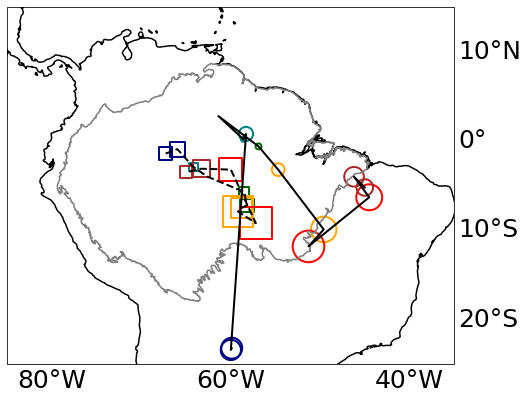

In [91]:
obj_pr(sam_ctl_loni, sam_ctl_lati, sam_def_loni, sam_def_lati, sam_ctl_tas, sam_def_tas, -30, 20, -90, -30)

In [109]:
map_diff = tas_def_land_month - tas_ctl_land_month

In [130]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

def contourf(ax, data, cmap, varmin, varmax, space, extend, title):
    # Define plot extent and add coastlines
    ax.set_extent([-85, -35, -20, 10])
    ax.coastlines('50m', linewidth=0.8)

    # Configure gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=1.5, color='gray',
                      xlocs=range(-180, 180, 20), ylocs=range(-90, 90, 10),
                      crs=ccrs.PlateCarree())
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style, gl.ylabel_style = {'fontsize': 10}, {'fontsize': 10}
    gl.xlabels_top = False
    gl.ylabels_left = False
    gl.xlines = False
    gl.ylines = False

    # Define lat and lon from data
    lats = data.lat
    lons = data.lon

    # Plot data using pcolormesh
    m = ax.pcolormesh(lons, lats, data, cmap=cmap, vmin=varmin, vmax=varmax, transform=ccrs.PlateCarree())

    # Plot contour (optional boundary)
    kw = {'levels': [-1], 'colors': ['lightgrey'], 'linestyles': ['solid']}
    AMZ_BD.plot.contour(ax=ax, transform=ccrs.PlateCarree(), **kw)

    # Set title for each subplot
    ax.set_title(title, fontsize=15)

    return m

In [135]:
RdBu_r_new = Tools.colormap_create('RdBu_r',21,10,11)
Reds_new = Tools.colormap_create('Reds',21,0,1)

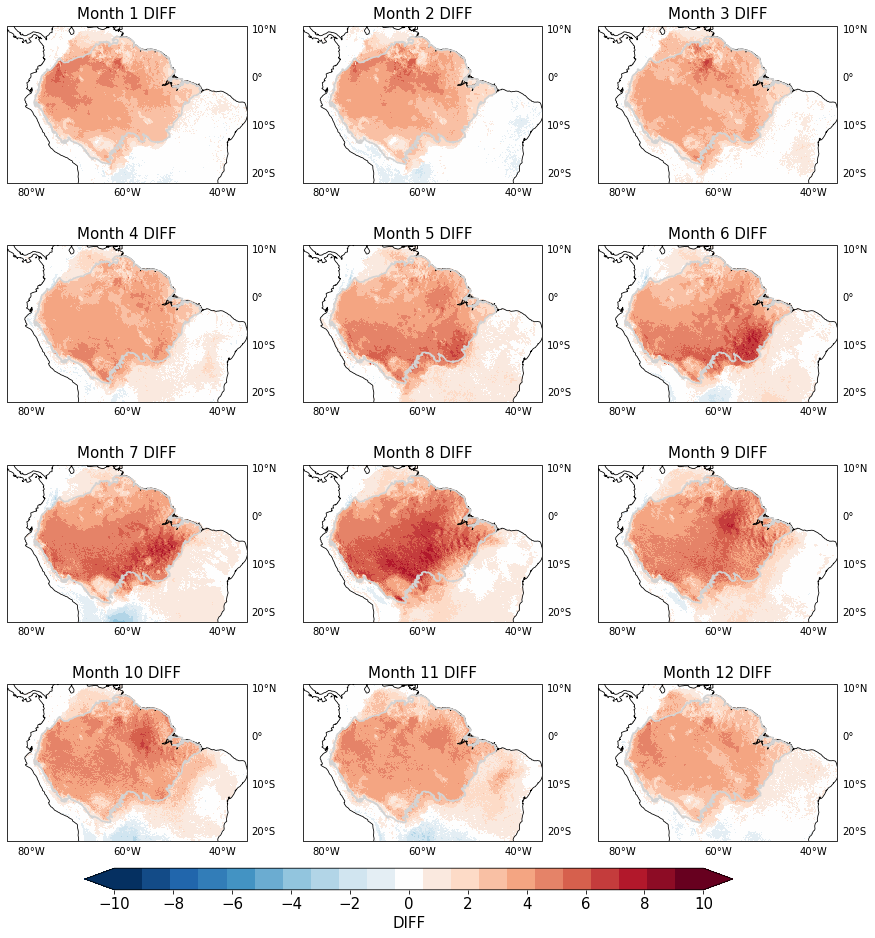

In [134]:
import matplotlib.colors as mcolors
# Define the 4x3 grid and plot the 12 maps
fig, axes = plt.subplots(4, 3, figsize=(15, 15), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
fig.subplots_adjust(hspace=0.4, wspace=0.2)  # Adjust spacing between subplots

# Loop through each subplot to add data
for i, ax in enumerate(axes.flat):  # .flat iterates over axes in a 2D grid
    if i < 12:  # Ensure we only plot the first 12 months
        data_i = map_diff.where(map_diff != 0).isel(month=i)
        m = contourf(ax, data_i, RdBu_r_new, -10, 10, 11, 'both', f'Month {i+1} DIFF')

# Add a colorbar that spans all subplots
cbar_ax = fig.add_axes([0.2, 0.08, 0.6, 0.02])  # Position: [left, bottom, width, height]
bounds = np.linspace(-10, 10, 11)
cb = fig.colorbar(m, cax=cbar_ax, orientation='horizontal', extend='both', ticks=bounds)
cb.ax.tick_params(labelsize=15)
cb.set_label('DIFF', fontsize=15)

plt.show()

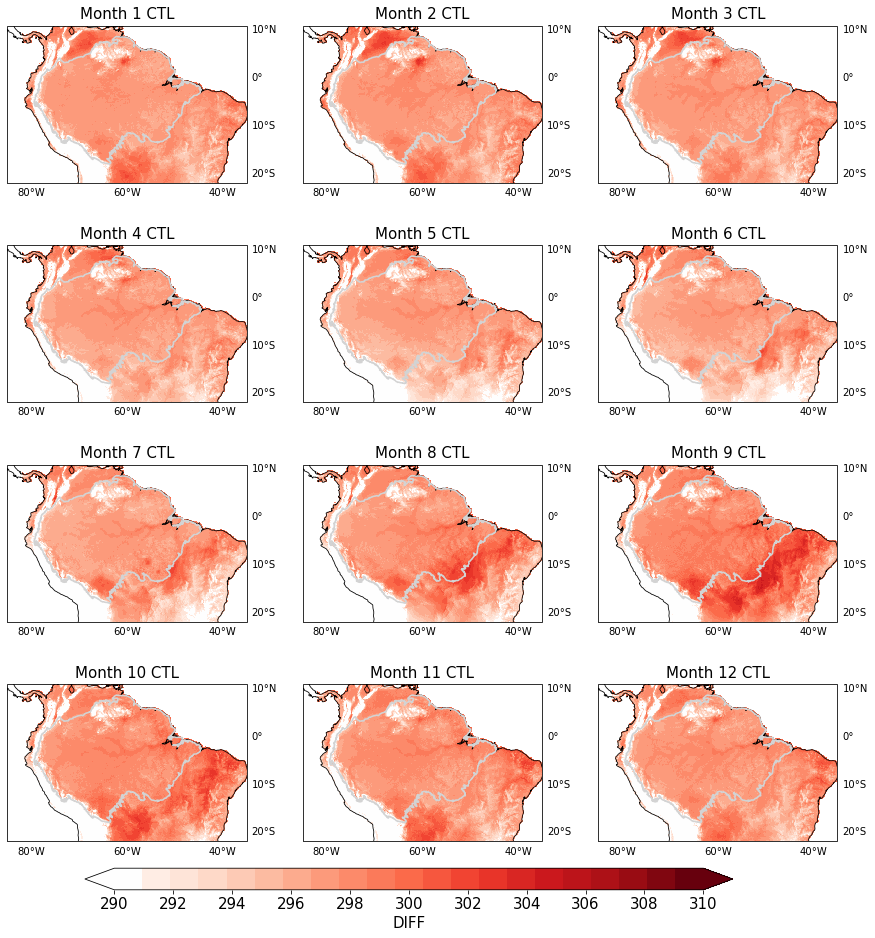

In [137]:
import matplotlib.colors as mcolors
# Define the 4x3 grid and plot the 12 maps
fig, axes = plt.subplots(4, 3, figsize=(15, 15), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
fig.subplots_adjust(hspace=0.4, wspace=0.2)  # Adjust spacing between subplots

# Loop through each subplot to add data
for i, ax in enumerate(axes.flat):  # .flat iterates over axes in a 2D grid
    if i < 12:  # Ensure we only plot the first 12 months
        data_i = tas_ctl_land_month.where(tas_ctl_land_month != 0).isel(month=i)
        m = contourf(ax, data_i, Reds_new, 290, 310, 11, 'both', f'Month {i+1} CTL')

# Add a colorbar that spans all subplots
cbar_ax = fig.add_axes([0.2, 0.08, 0.6, 0.02])  # Position: [left, bottom, width, height]
bounds = np.linspace(290, 310, 11)
cb = fig.colorbar(m, cax=cbar_ax, orientation='horizontal', extend='both', ticks=bounds)
cb.ax.tick_params(labelsize=15)
cb.set_label('DIFF', fontsize=15)

plt.show()

# Diurnal cycle

In [7]:
tas_ctl_diurnal = tas_ctl_mask.mean(dim=('lat','lon')).groupby('time.hour').mean(dim='time')
tas_def_diurnal = tas_def_mask.mean(dim=('lat','lon')).groupby('time.hour').mean(dim='time')

In [12]:
dew2_ctl_diurnal = dew2_ctl_mask.mean(dim=('lat','lon')).groupby('time.hour').mean(dim='time')
dew2_def_diurnal = dew2_def_mask.mean(dim=('lat','lon')).groupby('time.hour').mean(dim='time')

In [8]:
tas_ctl_diurnal_values = tas_ctl_diurnal.values
tas_def_diurnal_values = tas_def_diurnal.values

In [14]:
dew2_ctl_diurnal_values = dew2_ctl_diurnal.values
dew2_def_diurnal_values = dew2_def_diurnal.values

In [11]:
print(np.max(tas_ctl_diurnal_values) - np.min(tas_ctl_diurnal_values), np.max(tas_def_diurnal_values) - np.min(tas_def_diurnal_values))

5.9931335 8.798462


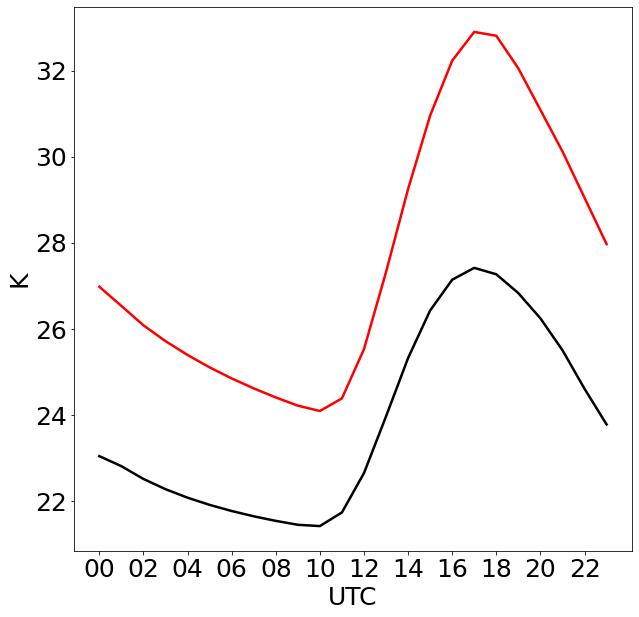

In [13]:
import matplotlib.dates as mdates
plt.figure(figsize=(10, 10))
plt.plot(tas_ctl_diurnal_values-273, label='ctl', c='black', linewidth=2.5)
plt.plot(tas_def_diurnal_values-273, label='def', c='red', linewidth=2.5)

plt.xlabel('UTC', fontsize=25)
plt.ylabel('K', fontsize=25)
#plt.title('Vertical Distribution of Cloud Water Content Over Time')

hours = np.arange(0, 24, 2)
labels = [f'{hour:02d}' for hour in hours]
plt.xticks(ticks=hours, labels=labels,rotation=0, fontsize=25)
plt.yticks(fontsize=25)

# Format the x-axis to show only the time

# Show the plot
plt.show()

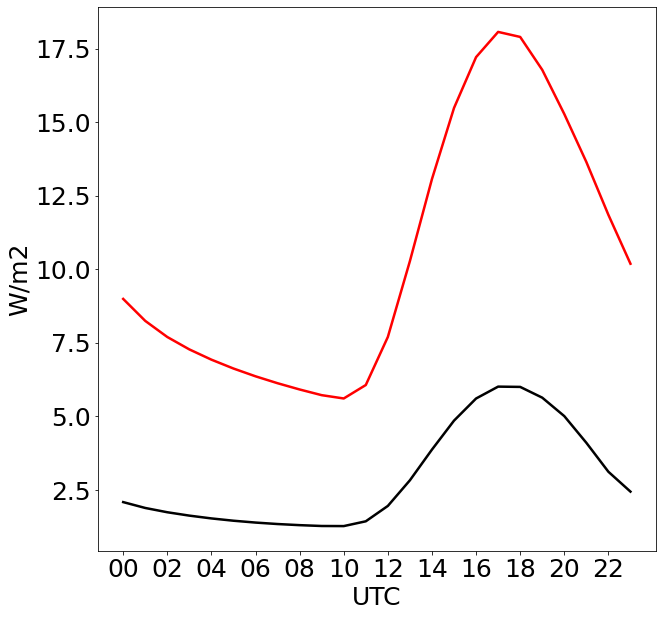

In [21]:
import matplotlib.dates as mdates
plt.figure(figsize=(10, 10))
plt.plot(ts_ctl_diurnal_values-dew2_ctl_diurnal.sel(height_2=2), label='ctl', c='black', linewidth=2.5)
plt.plot(ts_def_diurnal_values-dew2_def_diurnal.sel(height_2=2), label='def', c='red', linewidth=2.5)

plt.xlabel('UTC', fontsize=25)
plt.ylabel('W/m2', fontsize=25)
#plt.title('Vertical Distribution of Cloud Water Content Over Time')

hours = np.arange(0, 24, 2)
labels = [f'{hour:02d}' for hour in hours]
plt.xticks(ticks=hours, labels=labels,rotation=0, fontsize=25)
plt.yticks(fontsize=25)

# Format the x-axis to show only the time

# Show the plot
plt.show()

In [26]:
ctl_tas_avg = np.mean(tas_ctl_diurnal_values)
def_tas_avg = np.mean(tas_def_diurnal_values)
print(def_tas_avg - ctl_tas_avg)

3.75


In [27]:
ctl_dp_avg = np.mean(tas_ctl_diurnal_values)-np.mean(dew2_ctl_diurnal_values)
def_dp_avg = np.mean(tas_def_diurnal_values)-np.mean(dew2_def_diurnal_values)
print(def_dp_avg - ctl_dp_avg)

6.6289673


# standard deviation of daily mean temperature

In [7]:
tas_ctl_mask_1d = tas_ctl_mask.isel(height_2=0).resample(time='1D').mean(dim='time')
tas_ctl_mask_1d_std = tas_ctl_mask_1d.std(dim='time')

In [8]:
tas_def_mask_1d = tas_def_mask.isel(height_2=0).resample(time='1D').mean(dim='time')
tas_def_mask_1d_std = tas_def_mask_1d.std(dim='time')

In [9]:
diff_tas_std = tas_def_mask_1d_std - tas_ctl_mask_1d_std

/home/m/m300948/.conda/envs/JUPYTER_MODULE/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/m/m300948/.conda/envs/JUPYTER_MODULE/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


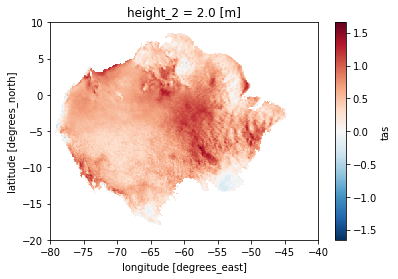

In [10]:
diff_tas_std.plot()